In [1]:
import os
import PIL
import glob
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.random import set_seed

### Data Preparation

In [2]:
# Define paths
train_path = "AI/datasets/Vegetable Images/train"
val_path = "AI/datasets/Vegetable Images/validation"
test_path = "AI/datasets/Vegetable Images/test"

In [3]:
# Initialize data dictionaries and labels
data_dicts = {"train": [], "test": [], "val": []}
data_labels = {"train": [], "test": [], "val": []}

In [4]:
# Prepare data
for phase in ["train", "val", "test"]:
    if phase == "train":
        data_dir = train_path
    elif phase == "val":
        data_dir = val_path
    else:
        data_dir = test_path
    
    class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names)
    
    image_files = [
        [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
        for i in range(num_class)
    ]
    
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = []
    image_class = []
    
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    
    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f"{phase} information")
    print(f"Image dimensions: {image_width} x {image_height}")
    print(f"Label names: {class_names}")
    print(f"Label counts: {num_each}")
    print(f"Total image count: {num_total}")
    print("--" * 8)

train information
Image dimensions: 224 x 224
Label names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Label counts: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Total image count: 15000
----------------
val information
Image dimensions: 224 x 224
Label names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Label counts: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Total image count: 3000
----------------
test information
Image dimensions: 224 x 224
Label names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Label counts: [200, 200

In [5]:
df = pd.DataFrame({"path": data_dicts["train"], "label": data_labels["train"]})
sorted_counts = df.value_counts("label")
fig = px.pie(
    names=class_names,
    values=sorted_counts,
    title="Class Distribution in Trainset",
    hole=0.3,
)
fig.show()

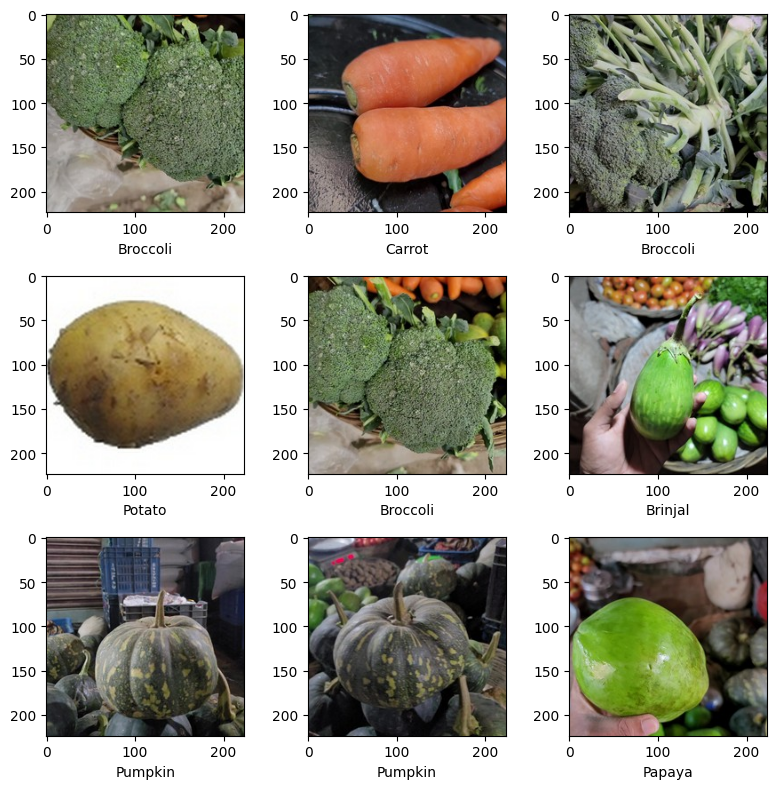

In [6]:
# Display images with labels
plt.figure(figsize=(8, 8))
for i, k in enumerate(np.random.randint(len(data_dicts["train"]), size=9)):
    im = PIL.Image.open(data_dicts["train"][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[data_labels["train"][k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### Data Loading

#### Initialize Generator

In [7]:
batch_size = 32
data_generator = {
    "train": ImageDataGenerator(
        rescale=1 / 255.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        rotation_range=10,
    ),
    "val": ImageDataGenerator(
        rescale=1 / 255.0, 
        width_shift_range=0.1, 
        height_shift_range=0.1
    ),
    "test": ImageDataGenerator(
        rescale=1 / 255.0
        ),
}

#### Load Data

In [8]:
image_height = 224
image_width = 224

# Create data generators
data_sets = {
    "train": data_generator["train"].flow_from_directory(
        train_path,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical'
    ),
    "val": data_generator["val"].flow_from_directory(
        val_path,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical'
    ),
    "test": data_generator["test"].flow_from_directory(
        test_path,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical'
    )
}

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [11]:
# Check the output of the generators
train_batch = next(data_sets["train"])
val_batch = next(data_sets["val"])
test_batch = next(data_sets["test"])

print(f'Train batch shape: {train_batch[0].shape}, Train labels shape: {train_batch[1].shape}')
print(f'Val batch shape: {val_batch[0].shape}, Val labels shape: {val_batch[1].shape}')
print(f'Test batch shape: {test_batch[0].shape}, Test labels shape: {test_batch[1].shape}')

Train batch shape: (32, 224, 224, 3), Train labels shape: (32, 15)
Val batch shape: (32, 224, 224, 3), Val labels shape: (32, 15)
Test batch shape: (32, 224, 224, 3), Test labels shape: (32, 15)


In [12]:
for i, (images, labels) in enumerate(data_sets["train"]):
    print("labels of first batch in trainset:", labels)
    print(labels.shape)
    print(images.shape)
    break

labels of first batch in trainset: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

#### Data Visualization

In [13]:
def show_images(GRID=[3, 3], model=None, size=(8, 8), data=data_sets["train"], class_names=class_names):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        # Lấy ngẫu nhiên một hình ảnh và nhãn từ batch
        id = np.random.randint(images.shape[0])
        image = images[id]
        label_index = np.argmax(labels[id])  # Chuyển one-hot encoding thành chỉ số lớp
        label = class_names[label_index]

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred_probs = model.predict(image[np.newaxis, ...])[0]  # Dự đoán xác suất cho từng lớp
            pred_index = np.argmax(pred_probs)  # Lấy chỉ số của lớp có xác suất cao nhất
            pred = class_names[pred_index]
            title = f"Org : {label}, Pred : {pred}"
            # Test
            print(pred_probs)
            print(pred_index)
            print(pred)

        plt.title(title)
        plt.axis("off")

        i += 1
        if (i > n_images):
            break

    plt.tight_layout()
    plt.show()


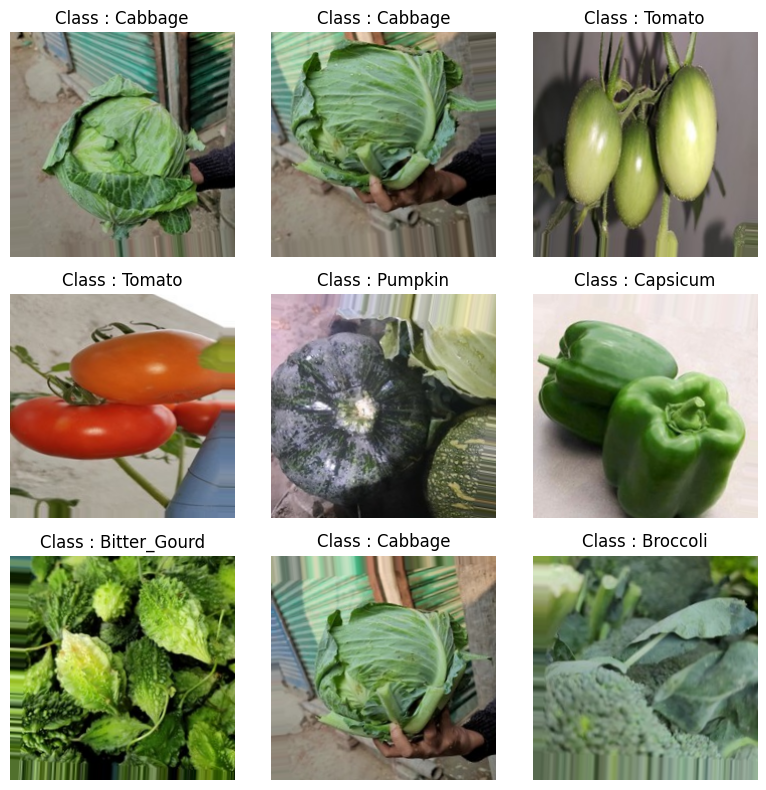

In [14]:
show_images()

In [15]:
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


### Model

#### Model Selection

In [16]:
pretrained = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=[image_height, image_width, 3], include_top=False, weights="imagenet",
)
pretrained.trainable = False

model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(image_height, image_width, 3)),
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(15, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,947,663 (11.24 MB)

 Trainable params: 689,679 (2.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Visualising Model Architecture

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "vegetables.keras", save_best_only=True
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"]
)
epochs = 15
history = model.fit(
    data_sets["train"],
    validation_data=data_sets["val"],
    epochs=epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
 )

Epoch 1/15


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



469/469 ━━━━━━━━━━━━━━━━━━━━ 164s 343ms/step - accuracy: 0.8628 - loss: 0.4693 - val_accuracy: 0.9890 - val_loss: 0.0339
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 155s 327ms/step - accuracy: 0.9845 - loss: 0.0529 - val_accuracy: 0.9940 - val_loss: 0.0199
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 154s 326ms/step - accuracy: 0.9912 - loss: 0.0285 - val_accuracy: 0.9887 - val_loss: 0.0417
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 332ms/step - accuracy: 0.9938 - loss: 0.0218 - val_accuracy: 0.9947 - val_loss: 0.0235
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 158s 334ms/step - accuracy: 0.9950 - loss: 0.0178 - val_accuracy: 0.9947 - val_loss: 0.0258
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 154s 325ms/step - accuracy: 0.9955 - loss: 0.0163 - val_accuracy: 0.9950 - val_loss: 0.0160
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 316ms/step - accuracy: 0.9965 - loss: 0.0117 - val_accuracy: 0.9937 - val_loss: 0.0176
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 316ms/step - accuracy: 0.9960 - loss: 0.01

In [20]:
history_df = pd.DataFrame(history.history)

In [21]:
history_df


accuracy      loss  val_accuracy  val_loss
0   0.945800  0.188336      0.989000  0.033938
1   0.987600  0.042534      0.994000  0.019918
2   0.991467  0.026746      0.988667  0.041685
3   0.993600  0.022547      0.994667  0.023522
4   0.994933  0.018989      0.994667  0.025813
5   0.995533  0.016644      0.995000  0.016038
6   0.996133  0.013405      0.993667  0.017628
7   0.995933  0.014201      0.992333  0.038130
8   0.995667  0.015041      0.995667  0.016162
9   0.996733  0.010154      0.995333  0.014555
10  0.997067  0.010298      0.995667  0.025135
11  0.995333  0.016945      0.997333  0.011481
12  0.997867  0.009035      0.996333  0.016417
13  0.998600  0.005376      0.997667  0.011023
14  0.997667  0.011504      0.997000  0.009889

In [22]:
line = px.line(data_frame= history_df ,y =["accuracy","val_accuracy"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_layout(showlegend = True,
    title = {
        'text': 'train acc Vs. val acc',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

In [23]:
line = px.line(data_frame= history_df ,y =["loss" , "val_loss"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Loss")
line.update_layout(showlegend = True,
    title = {
        'text': 'train loss Vs. val loss',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

#### Load Model

In [24]:
model = load_model("vegetables.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,327,023 (16.51 MB)

 Trainable params: 689,679 (2.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,379,360 (5.26 MB)

#### Model Evaluation

In [25]:
score = model.evaluate(data_sets['test'])

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.9989 - loss: 0.0022


In [26]:
print('{}:{}'.format(model.metrics_names[1],score[1]*100))
print('{}:{}'.format(model.metrics_names[0],score[0]))

compile_metrics:99.90000128746033
loss:0.0019581548403948545


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
[1.0000000e+00 1.2947489e-21 2.6840785e-18 1.0916072e-21 4.2008334e-24
 8.1239484e-26 5.9769364e-27 3.0039546e-23 5.0395893e-23 1.0457730e-18
 2.3931987e-23 9.2321509e-27 4.6171402e-34 2.4943951e-17 5.6214791e-19]
0
Bean


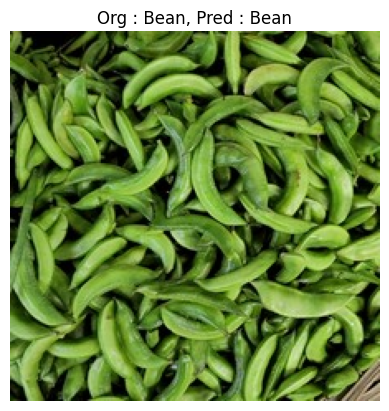

In [27]:
data = data_sets["test"]
for images, labels in data:
        # Lấy ngẫu nhiên một hình ảnh và nhãn từ batch
        id = np.random.randint(images.shape[0])
        image = images[id]
        label_index = np.argmax(labels[id])  # Chuyển one-hot encoding thành chỉ số lớp
        label = class_names[label_index]
        
        pred_probs = model.predict(image[np.newaxis, ...])[0]
        pred_index = np.argmax(pred_probs)
        pred = class_names[pred_index]
        print(pred_probs)
        print(pred_index)
        print(pred)
        title = f"Org : {label}, Pred : {pred}"
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
        plt.show()
        break;

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1.0000000e+00 1.5136775e-17 4.9467890e-13 3.3136519e-16 2.7035235e-16
 4.6308963e-20 1.3265673e-19 2.0589606e-17 3.4571981e-17 7.4526321e-16
 1.6631845e-18 1.4190585e-17 7.9455414e-26 3.5482019e-12 1.4239654e-14]
0
Bean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[1.0000000e+00 1.4857764e-14 7.1233763e-13 2.5497264e-14 2.0425025e-12
 1.8275805e-15 1.6480790e-16 1.4694884e-15 6.3208363e-14 1.0709641e-12
 1.0820547e-14 6.1566098e-18 2.3853705e-22 1.2019013e-11 8.2737647e-13]
0
Bean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[1.0000000e+00 2.0169842e-14 1.5090209e-11 1.8196035e-13 6.6082599e-16
 8.2554504e-16 1.3137964e-18 4.0847202e-15 7.2733618e-15 6.8165119e-11
 2.3135744e-17 5.4225514e-16 3.1963528e-22 5.4135956e-11 8.1807616e-12]
0
Bean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[7.3240477e-07 9.9966967e-01 1.6858300e-12 9.9943691e-07 3.2653011e-04
 3.2807138e-10 8.0048518e-10 8.1441849e-09 2.8505482e-08 2.0288544e-06
 3.2226864e-11 1.4974768e-11 3.4807886e-11 

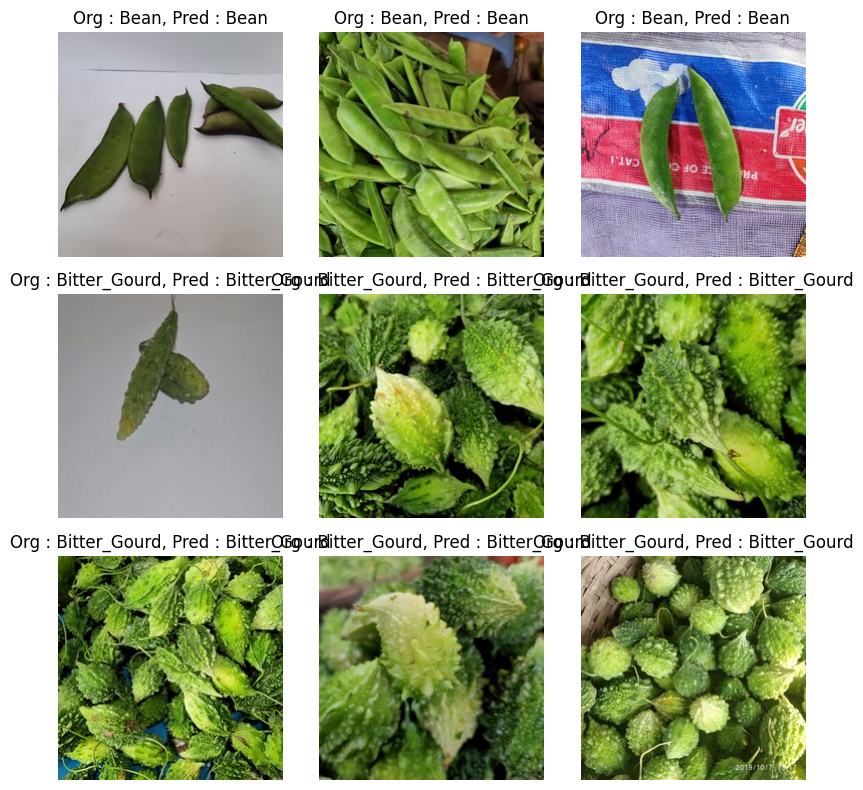

In [28]:
show_images(model=model, data=data_sets['test'])

##### Indicators Report

In [29]:
# Get true labels for the test set
y_true = data_sets['test'].classes

# Get predicted labels from the model
pred = np.argmax(model.predict(data_sets['test']), axis=1)

# Assuming you want to use all class names for the labels
labels = [class_names[i] for i in range(len(class_names))]

# Print classification report
print(classification_report(y_true, pred, target_names=labels))

94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step
              precision    recall  f1-score   support

        Bean       0.99      1.00      1.00       200
Bitter_Gourd       1.00      0.99      1.00       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      0.99      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       1.00      1.00      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      1.00      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00     

##### Confusion Matrix

In [30]:
classes = list(data_sets['test'].class_indices.keys())
real_classes = [classes[x] for x in data_sets['test'].labels]

pred = tf.argmax(model.predict(data_sets['test']),axis=1)
pred_classes = [classes[x] for x in pred]

94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 287ms/step


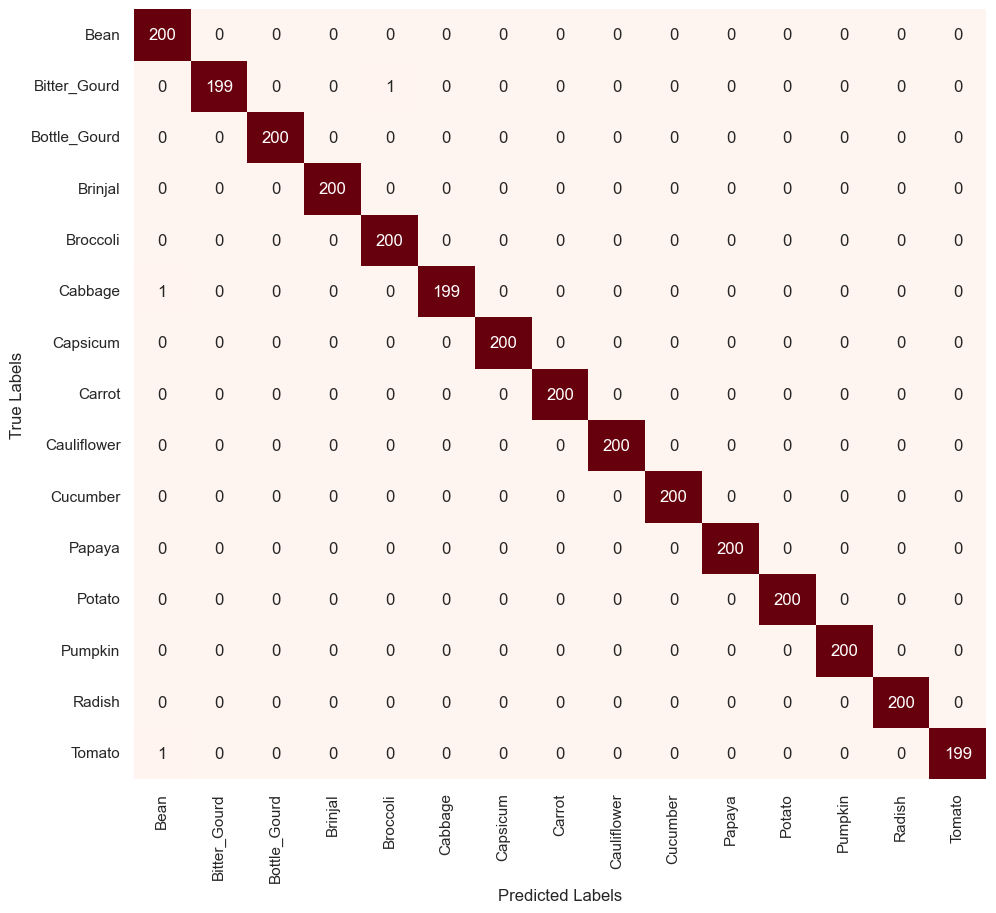

In [31]:
cf_matrix = metrics.confusion_matrix(real_classes,pred_classes)
sns.set_theme(rc={'figure.figsize':(11,10)})
ax = sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=classes,yticklabels=classes,cbar=False)
ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels');

#### Testing

In [32]:
model = load_model('vegetables.keras')

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

test_images_dir = "Testing_Images"

class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

image_files = os.listdir(test_images_dir)

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize hình ảnh về kích thước phù hợp với mô hình của bạn
    image = np.array(image) / 255.0  # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    if image.shape[-1] == 4:  # Nếu hình ảnh có kênh alpha, loại bỏ nó
        image = image[..., :3]
    return image

def show_and_predict_images(model, image_files, class_names, test_images_dir, grid=[6, 6], size=(8, 8)):
    n_rows = grid[0]
    n_cols = grid[1]
    n_images = n_rows * n_cols

    plt.figure(figsize=size)
    
    for i in range(n_images):
        if i >= len(image_files):
            break
        
        image_path = os.path.join(test_images_dir, image_files[i])
        image = preprocess_image(image_path)

        # Dự đoán lớp của hình ảnh
        pred_probs = model.predict(image[np.newaxis, ...])[0]
        pred_index = np.argmax(pred_probs)
        pred_class = class_names[pred_index]

        # Hiển thị hình ảnh và nhãn dự đoán
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {pred_class}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

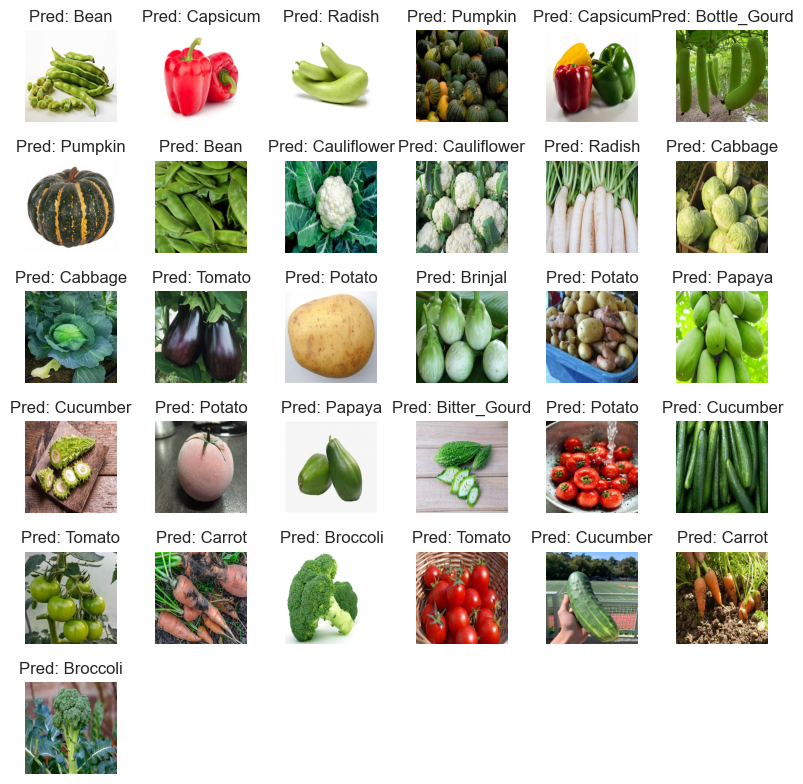

In [34]:
show_and_predict_images(model, image_files, class_names, test_images_dir)